In [13]:
# compare_instrumental.ipynb
# 用于生成 Figure 2: (a) 效率对比 vs (b) 超参数影响

import multiprocessing
import time
from functools import partial

import matplotlib.pyplot as plt
# In[1]:
# =============================================================================
# --- 1. 导入和设置 (Imports and Setup) ---
# =============================================================================
import numpy as np
import qutip as qt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# 从我们创建的模块中导入函数
from cspsa import run_cspsa_simulation
from sga import run_sga_simulation

In [14]:

# =============================================================================
# --- 2. 状态生成函数 (State Generation Functions) ---
# =============================================================================
# 在顶层定义基态
ket0, ket1 = qt.basis(2, 0), qt.basis(2, 1)
psi_pure = 1/np.sqrt(2) * (qt.tensor(ket0, ket0) + qt.tensor(ket1, ket1))
rho_pure = qt.ket2dm(psi_pure)

def generate_random_mixed_state():
    dm = qt.rand_dm(4, distribution='hs')
    dm.dims = [[2, 2], [2, 2]]
    return dm

In [15]:

# =============================================================================
# --- 3. ✅ 任务1a 配置: 效率对比 ---
# =============================================================================
# 固定超参数，对比不同量子态
ALGORITHMS_1a = {'CSPSA': run_cspsa_simulation, 'SGA': run_sga_simulation}
HPARAMS_1a = {
    'fixed': {
        'cspsa': (1.0, 1.0, 0.25, 1/6.0),
        'sga':   (1.0, 1.0, 0.25, 1/6.0),
    }
}
STATES_1a = {
    r"Max Entangled": rho_pure,
    "Random Mixed 1": generate_random_mixed_state(),
    "Random Mixed 2": generate_random_mixed_state(),
    "Random Mixed 3": generate_random_mixed_state(),
    "Random Mixed 4": generate_random_mixed_state(),
}
CONFIG_1a = {'iterations':40, 'num_repetitions': 30}

In [16]:

# =============================================================================
# --- 4. ✅ 任务1b 配置: 超参数影响 ---
# =============================================================================
# 固定量子态，对比不同超参数
ALGORITHMS_1b = {'CSPSA': run_cspsa_simulation, 'SGA': run_sga_simulation}
STATES_1b = {"Max Entangled": rho_pure}
HPARAMS_1b = {
    'default': {'cspsa': (1.0, 1.0, 0.25, 1/6.0), 'sga': (1.0, 1.0,  0.25,  1/6.0)},
    'high_a':  {'cspsa': (1.0*1.1, 1.0, 0.25, 1/6.0), 'sga': (1.0*1.1, 1.0,  0.25,  1/6.0)},
    'low_a':   {'cspsa': (1.0*0.9, 1.0, 0.25, 1/6.0), 'sga': (1.0*0.9, 1.0,  0.25,  1/6.0)},
    'high_s':  {'cspsa': (1.0, 1.0*1.1, 0.25, 1/6.0), 'sga': (1.0, 1.0*1.1,  0.25,  1/6.0)},
    'low_s':   {'cspsa': (1.0, 1.0*0.9, 0.25, 1/6.0), 'sga': (1.0, 1.0*0.9,  0.25,  1/6.0)},
    'high_b':  {'cspsa': (1.0, 1.0, 0.25*1.1, 1/6.0), 'sga': (1.0, 1.0,  0.25*1.1,  1/6.0)},
    'low_b':   {'cspsa': (1.0, 1.0, 0.25*0.9, 1/6.0), 'sga': (1.0, 1.0,  0.25*0.9,  1/6.0)},
    'high_r':  {'cspsa': (1.0, 1.0, 0.25, 1*1.1/6.0), 'sga': (1.0, 1.0,  0.25,  1*1.1/6.0)},
    'low_r':   {'cspsa': (1.0, 1.0, 0.25, 1*0.9/6.0), 'sga': (1.0, 1.0,  0.25,  1*0.9/6.0)},
}
CONFIG_1b = {'iterations': 100, 'num_repetitions': 30}

In [17]:

# =============================================================================
# --- 5. 实验执行循环 (Run Simulations) ---
# =============================================================================
def run_simulations(task_name, algorithms, hparams, states, config):
    all_results = []
    print(f"\n>>>>>> STARTING TASK: {task_name} <<<<<<")
    start_time = time.time()
    for hparam_name, hparam_values in hparams.items():
        for state_name, state_rho in states.items():
            for algo_name in algorithms:
                print(f"...Running: [Algo: {algo_name}] | [State: {state_name}] | [Hparam: {hparam_name}]...")
                current_config = {'state': state_rho, 'hparams': hparam_values, **config}
                worker_function = partial(algorithms[algo_name], current_config)
                with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
                    histories = pool.map(worker_function, range(config['num_repetitions']))
                mean_history = np.mean(np.abs(histories), axis=0)
                all_results.append({
                    'hparam_set': hparam_name,
                    'state_name': state_name,
                    'algo_name': algo_name,
                    'mean_history': mean_history
                })
    end_time = time.time()
    print(f">>>>>> TASK {task_name} COMPLETE IN {end_time - start_time:.2f} s <<<<<<\n")
    return all_results

if __name__ == '__main__':
    results_1a = run_simulations("1a: Efficiency", ALGORITHMS_1a, HPARAMS_1a, STATES_1a, CONFIG_1a)
results_1b = run_simulations("1b: Hyperparameters", ALGORITHMS_1b, HPARAMS_1b, STATES_1b, CONFIG_1b)



>>>>>> STARTING TASK: 1a: Efficiency <<<<<<
...Running: [Algo: CSPSA] | [State: Max Entangled] | [Hparam: fixed]...
  - [CSPSA] Starting Trial 11...
  - [CSPSA] Starting Trial 21...
...Running: [Algo: SGA] | [State: Max Entangled] | [Hparam: fixed]...
  - [SGA] Starting Trial 11...
  - [SGA] Starting Trial 21...
...Running: [Algo: CSPSA] | [State: Random Mixed 1] | [Hparam: fixed]...
  - [CSPSA] Starting Trial 11...
  - [CSPSA] Starting Trial 21...
...Running: [Algo: SGA] | [State: Random Mixed 1] | [Hparam: fixed]...
  - [SGA] Starting Trial 11...
  - [SGA] Starting Trial 21...
...Running: [Algo: CSPSA] | [State: Random Mixed 2] | [Hparam: fixed]...
  - [CSPSA] Starting Trial 11...
  - [CSPSA] Starting Trial 21...
...Running: [Algo: SGA] | [State: Random Mixed 2] | [Hparam: fixed]...
  - [SGA] Starting Trial 11...
  - [SGA] Starting Trial 21...
...Running: [Algo: CSPSA] | [State: Random Mixed 3] | [Hparam: fixed]...
  - [CSPSA] Starting Trial 11...
  - [CSPSA] Starting Trial 21...
..

Generating Figure 2...


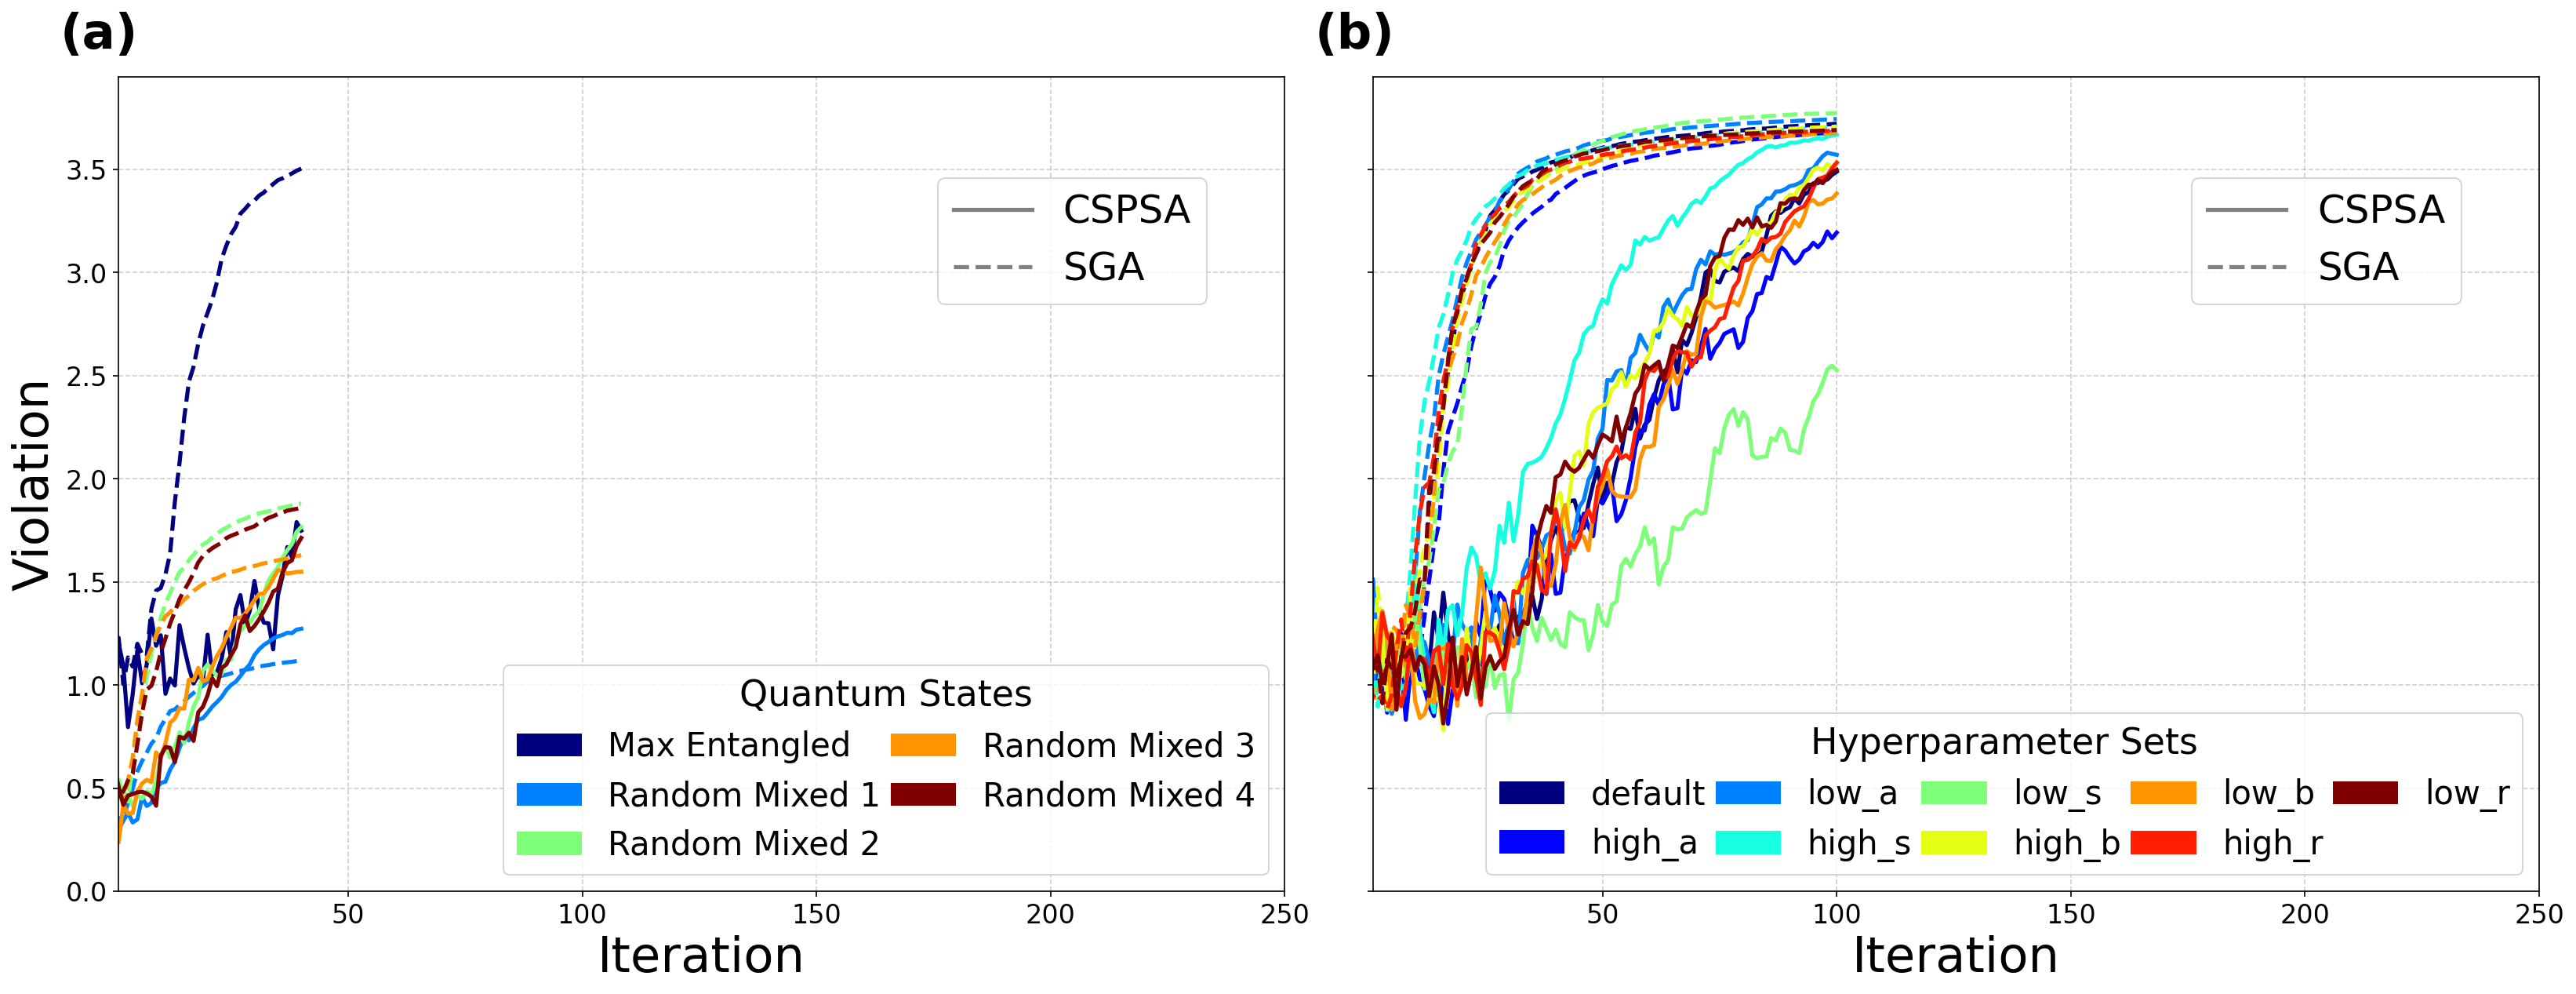

In [19]:
print("Generating Figure 2...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9), sharey=True, dpi=150)
plt.style.use('default')

# --- 图(a): 效率对比 ---
colors_1a = plt.cm.jet(np.linspace(0, 1, len(STATES_1a)))
state_colors = {name: colors_1a[i] for i, name in enumerate(STATES_1a.keys())}
algo_lines = {'CSPSA': '-', 'SGA': '--'}

for r in results_1a:
    ax1.plot(r['mean_history'],
            color=state_colors[r['state_name']],
            linestyle=algo_lines[r['algo_name']],
            linewidth=2.5)

ax1.text(-0.05, 1.08, '(a)', transform=ax1.transAxes, fontsize=30, fontweight='bold', va='top')

# 图例 (a)
leg_states = [Patch(facecolor=state_colors[name], label=name) for name in STATES_1a.keys()]
leg_algos = [Line2D([0], [0], color='gray', lw=2.5, linestyle=ls, label=name)
             for name, ls in algo_lines.items()]
legend1 = ax1.legend(handles=leg_states, loc='lower right', title='Quantum States',
                    ncol=2, columnspacing=0.3, fontsize=20, title_fontsize=22)
ax1.add_artist(legend1)
ax1.legend(handles=leg_algos, loc='upper right', bbox_to_anchor=(0.95, 0.900), fontsize=24)
ax1.set_xlim(1, 250)

# --- 图(b): 超参数影响 ---
colors_1b = plt.cm.jet(np.linspace(0, 1, len(HPARAMS_1b)))
hparam_colors = {name: colors_1b[i] for i, name in enumerate(HPARAMS_1b.keys())}

for r in results_1b:
    ax2.plot(r['mean_history'],
            color=hparam_colors[r['hparam_set']],
            linestyle=algo_lines[r['algo_name']],
            linewidth=2.5)

ax2.text(-0.05, 1.08, '(b)', transform=ax2.transAxes, fontsize=30, fontweight='bold', va='top')

# 图例 (b)
leg_hparams = [Patch(facecolor=hparam_colors[name], label=name) for name in HPARAMS_1b.keys()]
legend2 = ax2.legend(handles=leg_hparams, loc='lower right', ncol=5,
                    columnspacing=0.3, title='Hyperparameter Sets',
                    fontsize=20, title_fontsize=22)
ax2.add_artist(legend2)
ax2.legend(handles=leg_algos, loc='upper right', bbox_to_anchor=(0.95, 0.90), fontsize=24)
ax2.set_xlim(1, 250)

# --- 全局设置 ---
for ax in [ax1, ax2]:
    ax.set_xlabel("Iteration", fontsize=30)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis='both', which='major', labelsize=16)

ax1.set_ylabel("Violation", fontsize=30)
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig("figure2_instrumental_analysis.pdf", format='pdf', bbox_inches='tight')
plt.show()